In [1]:
import os
import io

from google.cloud import bigquery
from google.cloud import storage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle

In [2]:
def create_dataset(project_id, dataset_id):
    dataset_ref = f"{project_id}.{dataset_id}"
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = "US"  
    dataset = client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {dataset_id} created successfully in project {project_id}.")

In [3]:
def drop_table_if_exists(dataset_id, table_id):
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    try:
        client.delete_table(table_ref)
    except Exception as e:
        pass

In [4]:
def create_table(dataset_id, table_id, schema):
    drop_table_if_exists(dataset_id, table_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    table = bigquery.Table(table_ref, schema=schema)
    table = client.create_table(table, exists_ok=True)
    print(f"Table {table_id} created successfully in dataset {dataset_id}.")

In [5]:
def upload_to_bigquery(project_id, dataset_id, table_id, file_path, schema):
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    job_config = bigquery.LoadJobConfig(schema=schema,source_format=bigquery.SourceFormat.CSV,skip_leading_rows=1, write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE, )
    with open(file_path, "rb") as file:
        load_job = client.load_table_from_file(file, table_ref, job_config=job_config)
    load_job.result()
    print(f"Data uploaded successfully to {table_ref}.")

In [6]:
def executeSQLSelect(query):
    results = client.query(query).result()
    data = [dict(row.items()) for row in results]
    dataframe = pd.DataFrame(data)
    print(dataframe)

In [7]:
def create_gcs_bucket(bucket_name, location="US"):
    try:
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        if bucket.exists():
            print(f"Bucket '{bucket_name}' already exists. Deleting it.")
            bucket.delete(force=True)
            print(f"Bucket '{bucket_name}' deleted.")
        new_bucket = client.create_bucket(bucket, location=location)
        print(f"Bucket {new_bucket.name} created successfully in location {new_bucket.location}.")
    except Exception as e:
        print(f"Error creating bucket: {e}")

In [8]:
def upload_to_gcs(bucket_name, file_path, destination_blob_name):
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    if blob.exists():
        print(f"File {destination_blob_name} already exists in bucket {bucket_name}. Deleting it.")
        blob.delete()
        print(f"File {destination_blob_name} deleted.")
    blob.upload_from_filename(file_path)
    print(f"File {file_path} uploaded to {bucket_name}/{destination_blob_name}.")

In [9]:
def read_data_from_gcs(bucket_name, blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    data_string = blob.download_as_text()
    data = pd.read_csv(io.StringIO(data_string))
    print(f"Data read successfully from {bucket_name}/{blob}.")
    return data

In [10]:
def save_model_to_gcs(model, bucket_name, model_file_name):
    with open(model_file_name, 'wb') as model_file:
        pickle.dump(model, model_file)
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(model_file_name)
    blob.upload_from_filename(model_file_name)
    print(f"Model saved to GCS bucket {bucket_name} as {model_file_name}.")

In [11]:

restaurants_schema = [
    bigquery.SchemaField("RestaurantID", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("Name", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("Location", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("CuisineType", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Rating", "FLOAT", mode="NULLABLE"),
]

customers_schema = [
    bigquery.SchemaField("CustomerID", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("Name", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("Email", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Phone", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Address", "STRING", mode="NULLABLE"),
]

orders_schema = [
    bigquery.SchemaField("OrderID", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("CustomerID", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("RestaurantID", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("OrderDate", "DATE", mode="NULLABLE"),
    bigquery.SchemaField("OrderStatus", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("OrderAmount", "FLOAT", mode="NULLABLE"),
]

In [12]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "JSON_Key/g23ai2059-big-data-management-080dca6ac18e.json"
project_id = "g23ai2059-big-data-management"
dataset_id = "food_delivery_dataset"
bucket_name = "food-delivery-data-storage" 

In [13]:
client = bigquery.Client()
print("Connected to BigQuery. Project ID:", client.project)

Connected to BigQuery. Project ID: g23ai2059-big-data-management


In [14]:
create_dataset(project_id, dataset_id)
create_table(dataset_id, "Restaurants", restaurants_schema)
create_table(dataset_id, "Customers", customers_schema)
create_table(dataset_id, "Orders", orders_schema)

Dataset food_delivery_dataset created successfully in project g23ai2059-big-data-management.
Table Restaurants created successfully in dataset food_delivery_dataset.
Table Customers created successfully in dataset food_delivery_dataset.
Table Orders created successfully in dataset food_delivery_dataset.


In [15]:
upload_to_bigquery(project_id,dataset_id, "Customers", "Datasets/Customers.csv",customers_schema)
upload_to_bigquery(project_id,dataset_id, "Restaurants", "Datasets/Restaurants.csv",restaurants_schema)
upload_to_bigquery(project_id,dataset_id, "Orders", "Datasets/Orders.csv",orders_schema)

Data uploaded successfully to g23ai2059-big-data-management.food_delivery_dataset.Customers.
Data uploaded successfully to g23ai2059-big-data-management.food_delivery_dataset.Restaurants.
Data uploaded successfully to g23ai2059-big-data-management.food_delivery_dataset.Orders.


In [16]:
#Sample Data
query = f"SELECT * FROM `{project_id}.{dataset_id}.Orders` LIMIT 5"
executeSQLSelect(query)

    OrderID CustomerID RestaurantID   OrderDate OrderStatus  OrderAmount
0  43dc5b59   77fa426a     5f7eda1d  2024-01-03     Pending   378.028572
1  09d8a7e8   3e3126f9     9233a57b  2024-11-16     Pending  3527.272999
2  1762770d   7e1694ed     56bfc8e5  2024-11-01     Pending  3387.277801
3  63fa2742   fc8d7a74     53b56a12  2024-02-02     Pending   651.649166
4  2b92bfb0   8e0a8091     44ef930b  2023-12-25     Pending   270.569377


In [17]:
query_cnt = f"""
SELECT COUNT(*) count,'Orders' table FROM `{project_id}.{dataset_id}.Orders`
union all
SELECT COUNT(*) count,'Customers' table FROM `{project_id}.{dataset_id}.Customers`
union all
SELECT COUNT(*) count,'Restaurants' table FROM `{project_id}.{dataset_id}.Restaurants`
"""
executeSQLSelect(query_cnt)

   count        table
0   1000  Restaurants
1   1000       Orders
2   1000    Customers


In [18]:
q1 = f"""
SELECT RestaurantID, COUNT(*) as TotalOrders
FROM `{project_id}.{dataset_id}.Orders`
GROUP BY RestaurantID
ORDER BY 2 DESC
LIMIT 5;
"""
executeSQLSelect(q1)


  RestaurantID  TotalOrders
0     002e8a39            6
1     a91ed682            5
2     f2c3ee98            5
3     efa7bf09            5
4     8fbb95f8            5


In [19]:
client = storage.Client()  
print("Connected to Google Cloud Storage. Project ID:", client.project)

Connected to Google Cloud Storage. Project ID: g23ai2059-big-data-management


In [20]:
create_gcs_bucket(bucket_name)
upload_to_gcs(bucket_name, file_path= "Datasets/Restaurants.csv", destination_blob_name="Restaurants.csv" )
upload_to_gcs(bucket_name, file_path= "Datasets/Orders.csv", destination_blob_name="Orders.csv" )
upload_to_gcs(bucket_name, file_path= "Datasets/Customers.csv", destination_blob_name="Customers.csv" )

Bucket 'food-delivery-data-storage' already exists. Deleting it.
Bucket 'food-delivery-data-storage' deleted.
Bucket food-delivery-data-storage created successfully in location US.
File Datasets/Restaurants.csv uploaded to food-delivery-data-storage/Restaurants.csv.
File Datasets/Orders.csv uploaded to food-delivery-data-storage/Orders.csv.
File Datasets/Customers.csv uploaded to food-delivery-data-storage/Customers.csv.


In [21]:
data = read_data_from_gcs(bucket_name,"Orders.csv")

Data read successfully from food-delivery-data-storage/<Blob: food-delivery-data-storage, Orders.csv, 1733671540337003>.


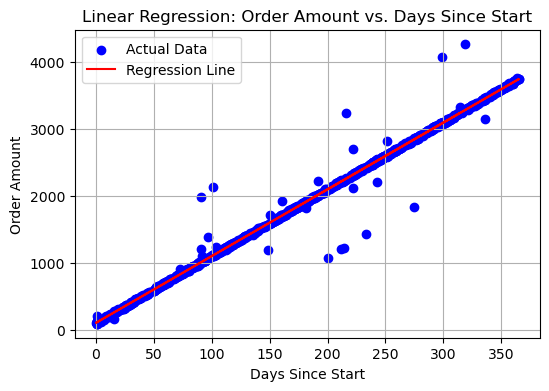

In [22]:
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['DaysSinceStart'] = (data['OrderDate'] - data['OrderDate'].min()).dt.days
X = data[['DaysSinceStart']]
y = data['OrderAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
data['PredictedOrderAmount'] = model.predict(data[['DaysSinceStart']])

plt.figure(figsize=(6, 4))
plt.scatter(data['DaysSinceStart'], data['OrderAmount'], color='blue', label='Actual Data')
plt.plot(data['DaysSinceStart'], data['PredictedOrderAmount'], color='red', label='Regression Line')
plt.xlabel("Days Since Start")
plt.ylabel("Order Amount")
plt.title("Linear Regression: Order Amount vs. Days Since Start")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model_file_name = "linear_regression_model.pkl"
save_model_to_gcs(model, bucket_name, model_file_name)

Model saved to GCS bucket food-delivery-data-storage as linear_regression_model.pkl.
